# Quantum MNIST

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import z_feature_map
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA, SPSA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import pandas as pd
from datasets import Dataset, DatasetDict

algorithm_globals.random_seed = 12345

/home/lsjcp/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        #qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        #qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

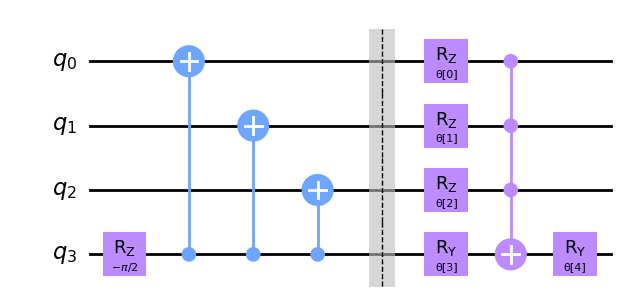

In [ ]:
def original_pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


def pool_circuit_odd_aestheic(params):
    target = QuantumCircuit(3)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.cx(1, 2)
    target.barrier()
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.rz(params[2], 2)
    target.ccx(0, 2, 1)
    target.ry(params[3], 1)

    return target

def pool_circuit_odd(params):
    target = QuantumCircuit(3)
    target.rz(-np.pi / 2, 2)
    target.cx(2, 1)
    target.cx(2, 0)
    target.barrier()
    target.rz(params[0], 0)
    target.rz(params[1], 1)
    target.ry(params[2], 2)
    target.ccx(0, 1, 2)
    target.ry(params[3], 2)

    return target

def generalized_pooling(num_qubits, params):
    """
    Generalized n->1 pooling block.
    All qubits [0..n-2] are pooled into qubit (n-1), the sink.
    """
    qc = QuantumCircuit(num_qubits)
    sink = num_qubits - 1
    sources = list(range(num_qubits - 1))

    # Basis change on sink (consistent with 2->1 pooling)
    qc.rz(-np.pi/2, sink)
    # Entangle sink with all sources
    for q in sources:
        qc.cx(sink, q)

    qc.barrier()

    # Local rotations on sources (discarded qubits)
    for i, q in enumerate(sources):
        qc.rz(params[i], q)

    # Initial rotation on sink
    qc.ry(params[len(sources)], sink)

    # Multi-controlled X (generalized Toffoli) from all sources into sink
    qc.mcx(sources, sink)

    # Final learnable rotation on sink
    qc.ry(params[len(sources)+1], sink)

    return qc

Sinks: [1, 4, 8, 12, 16, 19, 21]


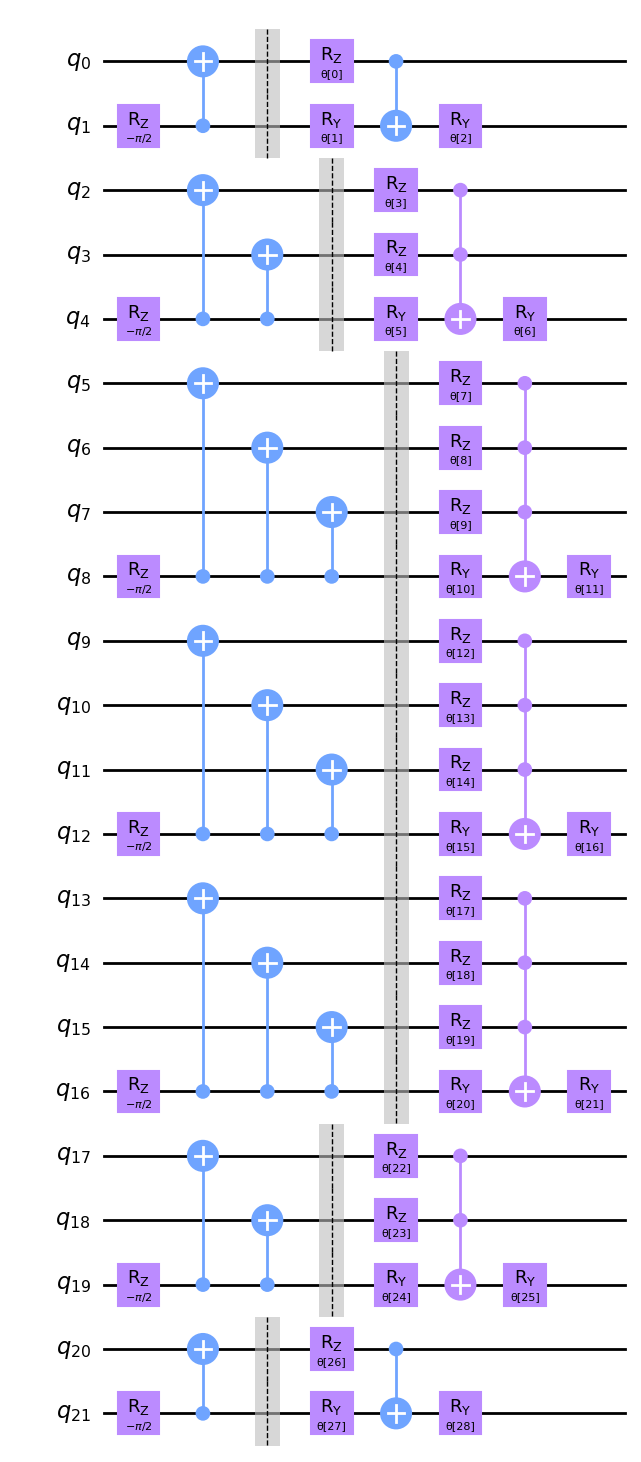

In [ ]:
def pool_layer(pools, param_prefix):
    """ poools is a 2d array where each row will be pooled into the list qbit of the group """
    num_qubits = sum(count for count in pools)
    param_count = sum(count + 1 for count in pools)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    circuit_index = 0
    sinks = []
    params = ParameterVector(param_prefix, param_count)
    for length in pools:
        sub_param_count = length + 1
        qbit_range = range(circuit_index, circuit_index + length)
        sub_params = params[param_index : (param_index + sub_param_count)]
        sub_circuit = generalized_pooling(length, sub_params)
        qc = qc.compose(sub_circuit, qbit_range)
        #qc.barrier()
        sinks.append(circuit_index + length - 1)
        param_index += sub_param_count
        circuit_index += length
    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return [qc, sinks]


## 3. Load MNIST Dataset

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict
from huggingface_hub import hf_hub_download, list_repo_files

def load_dataset_via_pandas(repo_id: str, revision: str = "main") -> DatasetDict:
    """
    Load a DatasetDict from a remote JSONL-based dataset repo on Hugging Face Hub
    using pandas as a backend to avoid ArrowIndexError.
    """
    files = list_repo_files(repo_id, repo_type="dataset", revision=revision)
    jsonl_files = [f for f in files if f.endswith(".jsonl")]

    dataset_dict = {}
    for f in jsonl_files:
        split = f.split("/")[-1].replace(".jsonl", "")
        
        local_path = hf_hub_download(repo_id, f, repo_type="dataset", revision=revision)
        
        df = pd.read_json(local_path, lines=True)
        dataset_dict[split] = Dataset.from_pandas(df, preserve_index=False)

    return DatasetDict(dataset_dict)


In [7]:
ds = load_dataset_via_pandas("ljcamargo/quantum_mnist")

In [9]:
def replace_nan_pixels(arr: np.ndarray, fill_value: complex = 0+0j) -> np.ndarray:
    """
    Replace NaN+NaN pixels in a complex array with a specified fill value.
    
    Args:
        arr : np.ndarray
            Complex array with NaNs for excluded pixels.
        fill_value : complex
            Value to replace NaN pixels with.
    
    Returns:
        np.ndarray : new array with NaNs replaced.
    """
    out = arr.copy()
    mask = np.isnan(arr.real) & np.isnan(arr.imag)
    out[mask] = fill_value
    return out

In [10]:
def get_topology_from_array(array):
    return [len([item for item in row if item != [None, None]]) for row in array]

In [ ]:
row = ds["train"][0]   # or ds["train"].shuffle()[42]
row_data = row["data"]

# Transposing the row data to match the expected format
row_data = [[row[i] for row in row_data] for i in range(len(row_data[0]))]

raw_complex_array = np.array([
    [
        complex(r if r is not None else np.nan, i if i is not None else np.nan)
        for r, i in row
    ]
    for row in row_data
])
raw_complex_array = raw_complex_array.T
topology = get_topology_from_array(row_data)
complex_array = replace_nan_pixels(np.array(raw_complex_array))

Topology [3, 5, 7, 7]
Real
[[ 0.          0.         -0.14960133 -0.08917248]
 [ 0.         -0.23303068  0.57338989 -0.475187  ]
 [-0.09547216 -0.09324744  0.28166863 -0.1730378 ]
 [ 0.00818379  0.14900014 -0.65630847  1.        ]
 [ 0.12745777 -0.23090863  0.12663865 -0.1730378 ]
 [ 0.          0.20799904 -0.00355326 -0.475187  ]
 [ 0.          0.          0.07578616 -0.08917249]]
Imaginary
[[ 0.          0.          0.0052153  -0.14660874]
 [ 0.          0.14562689 -0.1317421  -0.00898638]
 [ 0.02106659 -0.05398495  0.06041972  0.02067271]
 [-0.03059492  0.00588145  0.04521783  0.        ]
 [ 0.05029033 -0.11138549  0.12892017 -0.0206727 ]
 [ 0.          0.10138564 -0.08014845  0.00898637]
 [ 0.          0.         -0.10029694  0.14660874]]


In [13]:
import math

def restore_hermitian(truncated, original_shape):
    h, w = original_shape
    restored = np.zeros((h, w), dtype=truncated.dtype)
    restored[:, :truncated.shape[1]] = truncated
    
    truncated_w = truncated.shape[1]
    offset = 0 if w % 2 == 0 else -1 
    start_j = truncated_w + offset
    for j in range(1, start_j+1):
        restored[:, w - j] = np.conj(restored[::-1, j-1])
    
    return restored

def untruncate_fft(truncated, original_shape):
    """Untruncate FFT data back to original shape"""
    h, w = original_shape
    padded = np.zeros(original_shape, dtype=np.complex64)
    
    th, tw = truncated.shape
    top = math.ceil((h - th) / 2)
    left = math.ceil((w - tw) / 2)
    
    padded[top:top + th, left:left + tw] = truncated
    return padded

In [ ]:
truncated_shape = np.floor(np.array(row['original_shape']) * row['truncate_factor']).astype(int)
restored_hermitian = restore_hermitian(complex_array, truncated_shape)
restored_untruncated = untruncate_fft(restored_hermitian, row['original_shape'])
restored_unfft = np.fft.ifftn(np.fft.ifftshift(restored_untruncated), norm='forward')

Original MNIST Shape [28, 28]
Truncated Shape [7 7]


## Embed Complex Array from Image into Quantum Circuit

In [17]:
raw_complex_array = raw_complex_array.T # <- Transpose
print("Shape of the array", raw_complex_array.shape)

[w, h] = raw_complex_array.shape

# flatten
flat = raw_complex_array.flatten()
print("Flatened 1d array size", flat.shape)
# filter out "null" complex numbers (both real and imag are nan)
flat_filtered = flat[~(np.isnan(flat.real) & np.isnan(flat.imag))]
print("Flatened 1d array size minus Nan", flat_filtered.shape)
print("\nOriginal\n", raw_complex_array)
print("\nFlattened Array minus Nan\n", flat_filtered)

Shape of the array (4, 7)
Flatened 1d array size (28,)
Flatened 1d array size minus Nan (22,)

Original
 [[        nan       +nanj         nan       +nanj -0.09547216+0.02106659j
   0.00818379-0.03059492j  0.12745777+0.05029033j         nan       +nanj
          nan       +nanj]
 [        nan       +nanj -0.23303068+0.14562689j -0.09324744-0.05398495j
   0.14900014+0.00588145j -0.23090863-0.11138549j  0.20799904+0.10138564j
          nan       +nanj]
 [-0.14960133+0.0052153j   0.57338989-0.1317421j   0.28166863+0.06041972j
  -0.65630847+0.04521783j  0.12663865+0.12892017j -0.00355326-0.08014845j
   0.07578616-0.10029694j]
 [-0.08917248-0.14660874j -0.475187  -0.00898638j -0.1730378 +0.02067271j
   1.        +0.j         -0.1730378 -0.0206727j  -0.475187  +0.00898637j
  -0.08917249+0.14660874j]]

Flattened Array minus Nan
 [-0.09547216+0.02106659j  0.00818379-0.03059492j  0.12745777+0.05029033j
 -0.23303068+0.14562689j -0.09324744-0.05398495j  0.14900014+0.00588145j
 -0.23090863-0.11138

In [18]:
circuit_size = len(flat_filtered)
print("Qbit length", circuit_size)

Qbit length 22


#### Direct Parameter Binding

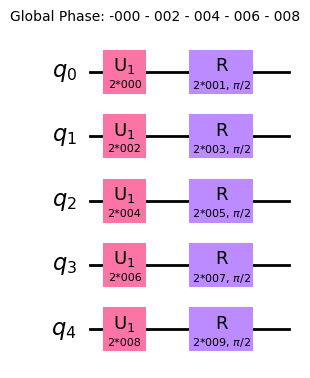

In [19]:
from qiskit.circuit import QuantumCircuit, Parameter

def create_complex_feature_map(qbit_count):
    n_features = qbit_count * 2
    qc = QuantumCircuit(qbit_count)
    
    # Create parameters for real and imaginary parts
    all_params = [
        Parameter(
            f'{i:03d}'
        ) for i in range(n_features)
    ]
    
    for i in range(qbit_count):
        current_param = i * 2
        qc.rz(2 * all_params[current_param], i)
        qc.ry(2 * all_params[current_param + 1], i)
    
    return qc

feature_map = create_complex_feature_map(qbit_count=5)
feature_map.decompose().draw("mpl", style="clifford")


In [20]:
print("Map params", feature_map.parameters)

Map params ParameterView([Parameter(000), Parameter(001), Parameter(002), Parameter(003), Parameter(004), Parameter(005), Parameter(006), Parameter(007), Parameter(008), Parameter(009)])


## Define Circuit

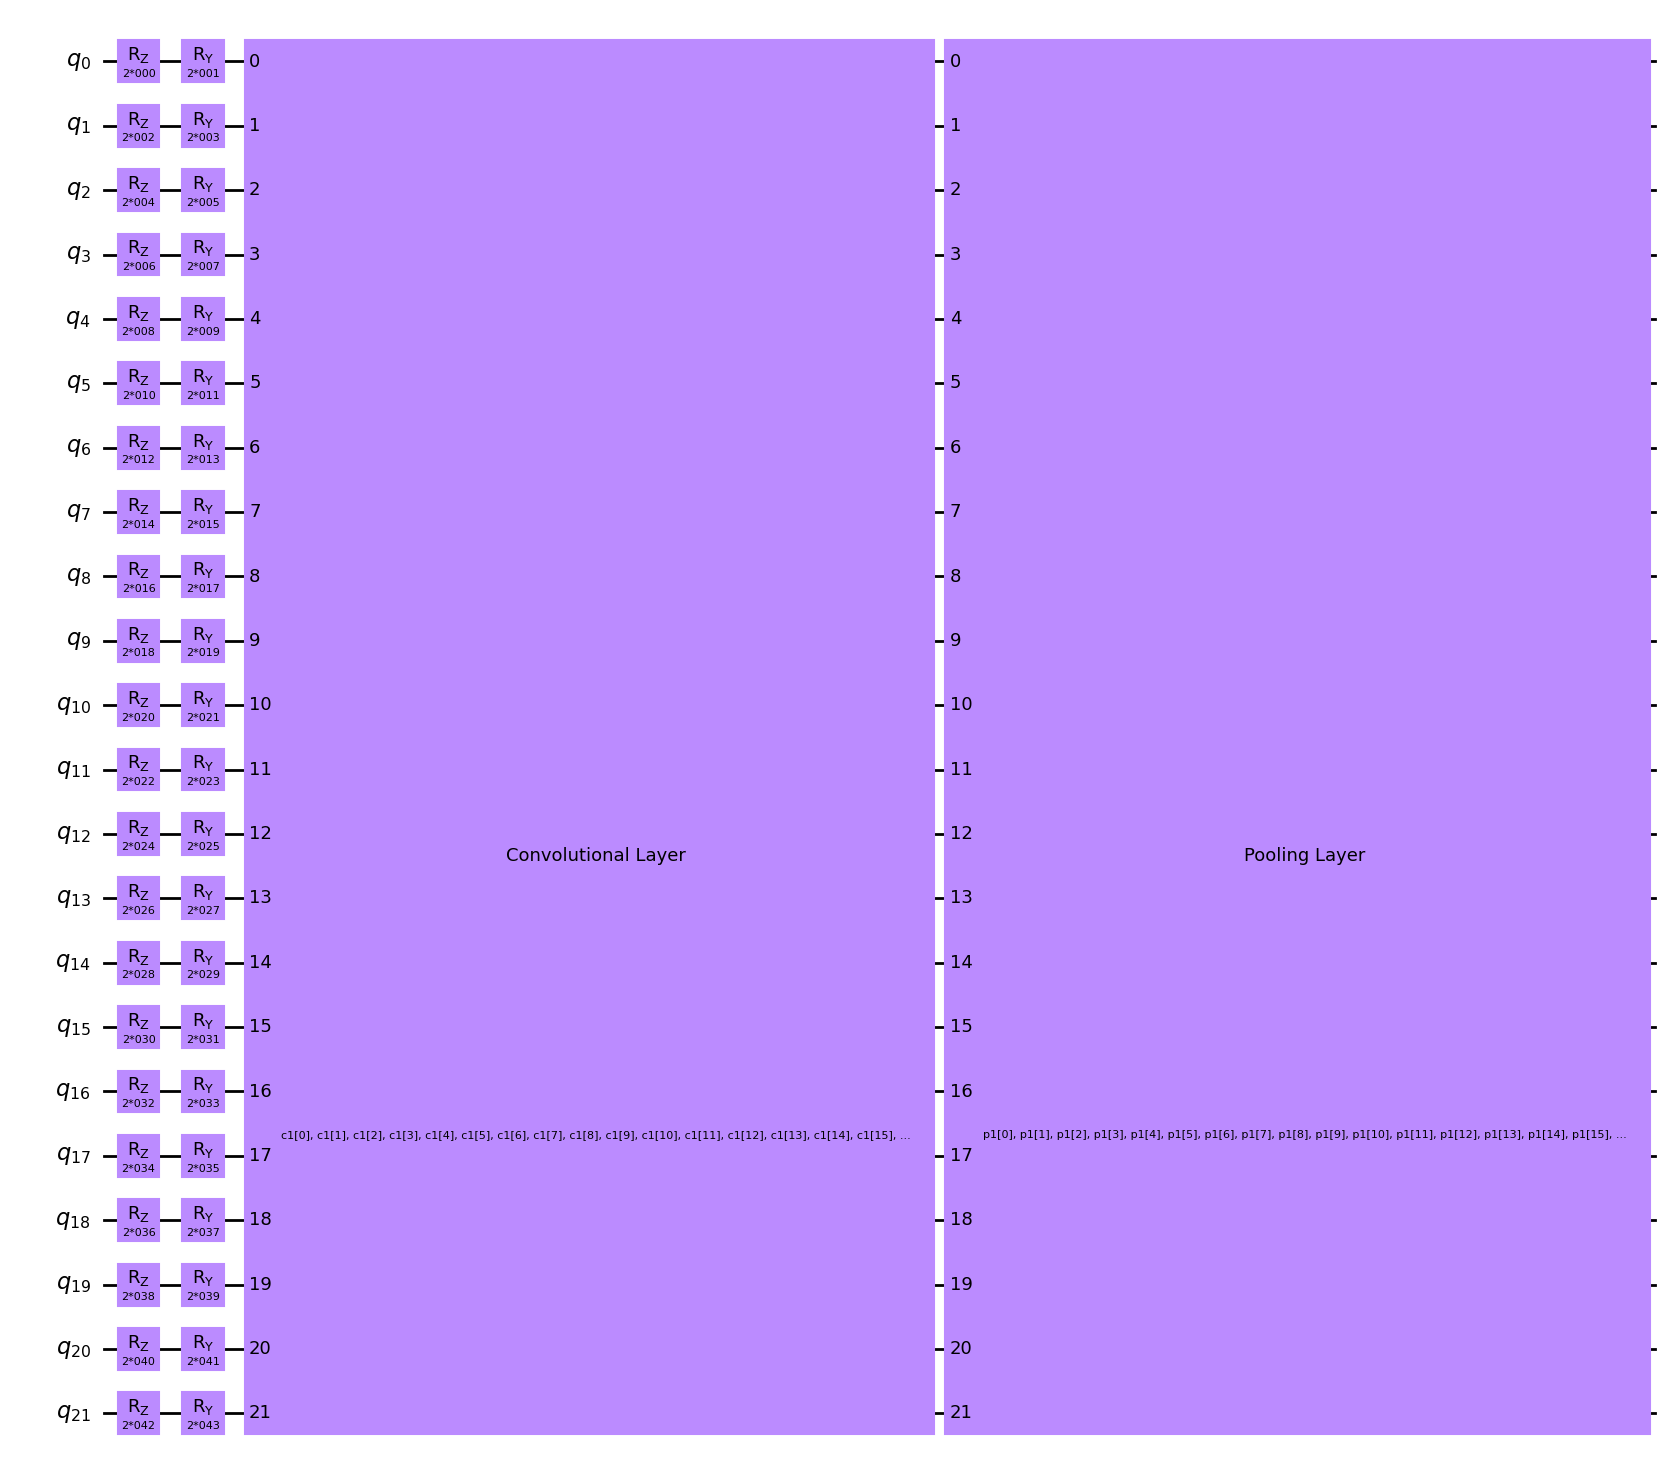

In [21]:
feature_map = create_complex_feature_map(qbit_count=circuit_size)
feature_map.draw("mpl", style="clifford")

ansatz = QuantumCircuit(circuit_size, name="Ansatz")

# First Convolutional Layer
convolution = conv_layer(circuit_size, "c1")
ansatz.compose(convolution, list(range(circuit_size)), inplace=True)

# First Pooling Layer
[pool, sinks] = pool_layer(topology, "p1")
ansatz.compose(pool, list(range(circuit_size)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(circuit_size, name="QNN Circuit")
circuit.compose(feature_map, range(circuit_size), inplace=True)
circuit.compose(ansatz, range(circuit_size), inplace=True)

circuit.draw("mpl", style="clifford")

In [ ]:
from qiskit.quantum_info import SparsePauliOp

def number_operator_from_indices(n_qubits, bit_indices, weights=None):
    """
    Build N = sum_k weights[k] * (I - Z(bit_indices[k]))/2
    - n_qubits: total number of qubits in the circuit
    - bit_indices: list of qubit indices that carry the result
                   (ordered LSB -> MSB)
    - weights: optional list of the same length; defaults to powers of 2
               [1, 2, 4, ...] in that LSB->MSB order
    """
    if weights is None:
        weights = [2**k for k in range(len(bit_indices))]

    paulis, coeffs = [], []

    for q, w in zip(bit_indices, weights):
        # + (w/2) * I...I
        paulis.append("I" * n_qubits)
        coeffs.append(w / 2)

        # - (w/2) * ...Z...
        z = ["I"] * n_qubits
        # Qiskit Pauli string order is MSB..LSB (left->right),
        # so put Z at position (n_qubits - 1 - q)
        z[n_qubits - 1 - q] = "Z"
        paulis.append("".join(z))
        coeffs.append(-w / 2)

    op = SparsePauliOp.from_list(list(zip(paulis, coeffs))).simplify()
    return op


In [23]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

def class_projector_observable(n_qubits, output_qubits, class_label):
    """
    Create a projector observable |class_label><class_label| on output_qubits
    - n_qubits: total qubits in circuit
    - output_qubits: list of qubit indices (LSB -> MSB)
    - class_label: integer, e.g., 0..9
    """
    binary = np.array(list(np.binary_repr(class_label, width=len(output_qubits))), dtype=int)
    # convert '0'/'1' to int array
    paulis = ["I"] * n_qubits
    coeff = 1.0

    # Start with coefficient 1 and multiply (I ± Z)/2 per bit
    terms = [("I"*n_qubits, 1.0)]  # initial term

    for qubit_idx, bit_val in zip(output_qubits, binary[::-1]):  # LSB->MSB
        new_terms = []
        for s, c in terms:
            # choose I+Z or I-Z
            s_list = list(s)
            s_list[n_qubits - 1 - qubit_idx] = "I"
            c_i = c * 0.5
            new_terms.append(("".join(s_list), c_i))
            
            s_list_z = list(s)
            s_list_z[n_qubits - 1 - qubit_idx] = "Z"
            c_z = c * (0.5 * (-1 if bit_val==1 else 1))
            new_terms.append(("".join(s_list_z), c_z))
        terms = new_terms

    # combine terms with same Pauli string
    from collections import defaultdict
    term_dict = defaultdict(float)
    for s, c in terms:
        term_dict[s] += c

    op = SparsePauliOp.from_list(list(term_dict.items())).simplify()
    return op

# Example: 22 qubits, output qubits at [2,7,14,21], class 3
class_projector_observable(22, [2,7,14,21], 0)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIII', 'ZIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIZIIIIIII', 'ZIIIIIIZIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIZIIIIIIIIIIIZII', 'ZIIIIIIZIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIZIIIIZII', 'ZIIIIIIIIIIIIIZIIIIZII', 'IIIIIIIZIIIIIIZIIIIZII', 'ZIIIIIIZIIIIIIZIIIIZII'],
              coeffs=[0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j])

In [24]:
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2

class_count = 10
observables = [class_projector_observable(circuit_size, sinks, k) for k in range(class_count)]
options = {
    "backend_options": {
        "method": "statevector",          # exact simulation
        "max_parallel_threads": 20,        # multi-thread CPU
    },
    "run_options": {
        "shots": 0                        # statevector -> no shots
    },
    "default_precision": 0.0
}
estimator = EstimatorV2(options=options)


# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observables,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [25]:
import json
from IPython.display import clear_output
import matplotlib.pyplot as plt

objective_func_vals = []
weights_history = []

def callback_graph(weights, obj_func_eval, 
                   checkpoint_interval=5, 
                   filename_obj="objective_values.json",
                   filename_weights="weights_checkpoint.json",
                   save_weights=True):
    """
    Original callback with optional JSON checkpointing.

    Args:
        weights: current optimizer parameters
        obj_func_eval: current objective function value
        checkpoint_interval: save weights every N iterations (default=5)
        filename_obj: file to store objective values (default="objective_values.json")
        filename_weights: file to store weights (default="weights_checkpoint.json")
        save_weights: whether to save weights (default=True)
    """
    # Append objective value
    objective_func_vals.append(obj_func_eval)
    
    # Save objective values every iteration
    with open(filename_obj, "w") as f:
        json.dump(objective_func_vals, f, indent=2)
    
    # Save weights every `checkpoint_interval` steps if enabled
    if save_weights:
        weights_history.append(weights.tolist() if hasattr(weights, "tolist") else list(weights))
        if len(weights_history) % checkpoint_interval == 0:
            with open(filename_weights, "w") as f:
                json.dump(weights_history, f, indent=2)
    
    # Plot objective function
    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.plot(range(len(objective_func_vals)), objective_func_vals, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.title("Objective function value vs Iteration")
    plt.grid(True)
    plt.show()


In [26]:
MAX_ITERS = 20
SAMPLES = 20

In [27]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=MAX_ITERS),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)

In [ ]:
def process_item(item):
    data = item["data"]
    # Transpose
    data = [[row[i] for row in data] for i in range(len(data[0]))]
    # Remove Nones
    data = [[pair for pair in row if pair[0]] for row in data]
    # Flatten
    data = [value for row in data for pair in row for value in pair]
    return {
        "features": data,
        "label": item["label"]
    }

{'features': [-0.095472157001495,
  0.021066591143608003,
  0.008183792233467001,
  -0.030594922602176004,
  0.12745776772499,
  0.050290331244468,
  -0.233030676841735,
  0.1456268876791,
  -0.093247435986995,
  -0.053984947502613005,
  0.14900013804435702,
  0.005881448742002001,
  -0.23090863227844202,
  -0.11138548702001501,
  0.20799903571605602,
  0.10138563811779001,
  -0.149601325392723,
  0.005215304903686001,
  0.5733898878097531,
  -0.131742104887962,
  0.281668633222579,
  0.060419723391532,
  -0.6563084721565241,
  0.045217830687761,
  0.126638650894165,
  0.128920167684555,
  -0.0035532638430590003,
  -0.080148451030254,
  0.075786158442497,
  -0.100296944379806,
  -0.08917247503995801,
  -0.14660874009132302,
  -0.47518700361251803,
  -0.008986375294625001,
  -0.17303779721260001,
  0.020672706887125,
  1.0,
  0.0,
  -0.17303779721260001,
  -0.02067270129919,
  -0.47518700361251803,
  0.008986374363303,
  -0.08917248994112001,
  0.14660874009132302],
 'label': 5}

Now lets map all the dataset into the structure [[features0, label0],[features1, label1]]

In [ ]:
processed_ds = ds["train"].select(range(SAMPLES)).map(process_item)
features = [sample["features"] for sample in processed_ds]
labels = [sample["label"] for sample in processed_ds]

Map: 100%|██████████| 20/20 [00:00<00:00, 1968.19 examples/s]

Sample features at 0: [-0.095472157001495, 0.021066591143608003, 0.008183792233467001, -0.030594922602176004, 0.12745776772499, 0.050290331244468, -0.233030676841735, 0.1456268876791, -0.093247435986995, -0.053984947502613005, 0.14900013804435702, 0.005881448742002001, -0.23090863227844202, -0.11138548702001501, 0.20799903571605602, 0.10138563811779001, -0.149601325392723, 0.005215304903686001, 0.5733898878097531, -0.131742104887962, 0.281668633222579, 0.060419723391532, -0.6563084721565241, 0.045217830687761, 0.126638650894165, 0.128920167684555, -0.0035532638430590003, -0.080148451030254, 0.075786158442497, -0.100296944379806, -0.08917247503995801, -0.14660874009132302, -0.47518700361251803, -0.008986375294625001, -0.17303779721260001, 0.020672706887125, 1.0, 0.0, -0.17303779721260001, -0.02067270129919, -0.47518700361251803, 0.008986374363303, -0.08917248994112001, 0.14660874009132302]
Sample label at 0: 5


In [30]:
from qiskit import QuantumCircuit
import numpy as np

def circuit_stats(circuit: QuantumCircuit, observables=None):
    """
    Print useful statistics for a QuantumCircuit to estimate resources and runtime.
    
    Parameters:
        circuit : QuantumCircuit
            The circuit to analyze.
        observables : list or SparsePauliOp, optional
            List of observables or a single observable to estimate number of Pauli terms.
    """
    print("===== Circuit Statistics =====")
    
    # Number of qubits
    n_qubits = circuit.num_qubits
    print("Number of qubits:", n_qubits)
    
    # Circuit depth
    depth = circuit.depth()
    print("Circuit depth:", depth)
    
    # Total number of instructions / gates
    instr_count = len(circuit.data)
    print("Total instructions in circuit:", instr_count)
    
    # Gate counts
    gate_count = circuit.count_ops()
    print("Gate counts:", gate_count)
    
    # Number of parameters
    param_count = len(circuit.parameters)
    print("Number of parameters:", param_count)
    
    # Estimated statevector memory
    mem_bytes = 2**n_qubits * 16  # complex128 = 16 bytes
    mem_mb = mem_bytes / 1024**2
    print(f"Estimated statevector memory: {mem_mb:.1f} MB")
    
    # Observables info
    if observables is not None:
        if hasattr(observables, "__len__") and not isinstance(observables, (str, QuantumCircuit)):
            num_observables = len(observables)
            total_pauli_terms = sum(len(o) for o in observables)
        else:  # single observable
            num_observables = 1
            total_pauli_terms = len(observables)
        print("Number of observables:", num_observables)
        print("Total number of Pauli terms:", total_pauli_terms)
    
    print("==============================")


In [31]:
circuit_stats(circuit.decompose(), observables)

===== Circuit Statistics =====
Number of qubits: 22
Circuit depth: 26
Total instructions in circuit: 276
Gate counts: OrderedDict([('rz', 88), ('cx', 84), ('ry', 52), ('u1', 22), ('r', 22), ('barrier', 4), ('mcx', 3), ('ccx', 1)])
Number of parameters: 136
Estimated statevector memory: 64.0 MB
Number of observables: 10
Total number of Pauli terms: 160


In [32]:
def estimate_runtime(circuit, observables, n_samples=1, device='cpu'):
    """
    Rough estimate of runtime for simulating a circuit with given observables.

    Parameters:
        circuit : QuantumCircuit
            The circuit to analyze.
        observables : list or SparsePauliOp
            List of observables or single observable.
        n_samples : int
            Number of input samples to evaluate.
        device : str
            'cpu' or 'gpu' to scale estimate.

    Returns:
        None (prints estimated time)
    """
    n_qubits = circuit.num_qubits
    depth = circuit.depth()
    
    # Handle observables
    if hasattr(observables, "__len__") and not isinstance(observables, (str, QuantumCircuit)):
        total_terms = sum(len(o) for o in observables)
        num_observables = len(observables)
    else:
        total_terms = len(observables)
        num_observables = 1

    # Base time per Pauli term per sample (rough)
    # These are empirical approximations for statevector simulation
    base_ms = 10  # ms per term for shallow circuit on CPU
    # scale linearly with depth relative to a “unit” depth 4
    base_ms *= depth / 4  

    # Scale for GPU
    if device.lower() == 'gpu':
        base_ms /= 5  # assume ~5x speedup

    # Total per sample
    time_per_sample_sec = total_terms * base_ms / 1000  # ms → sec

    # Total for all samples
    total_time_sec = n_samples * time_per_sample_sec

    print("===== Runtime Estimate =====")
    print(f"Circuit depth: {depth}")
    print(f"Number of qubits: {n_qubits}")
    print(f"Number of observables: {num_observables}")
    print(f"Total Pauli terms: {total_terms}")
    print(f"Number of samples: {n_samples}")
    print(f"Estimated time per sample: {time_per_sample_sec:.2f} sec")
    print(f"Estimated total time: {total_time_sec:.2f} sec ≈ {total_time_sec/60:.2f} min")
    print("============================")


In [33]:
estimate_runtime(circuit.decompose(), observables, n_samples=10, device='cpu')

===== Runtime Estimate =====
Circuit depth: 26
Number of qubits: 22
Number of observables: 10
Total Pauli terms: 160
Number of samples: 10
Estimated time per sample: 10.40 sec
Estimated total time: 104.00 sec ≈ 1.73 min


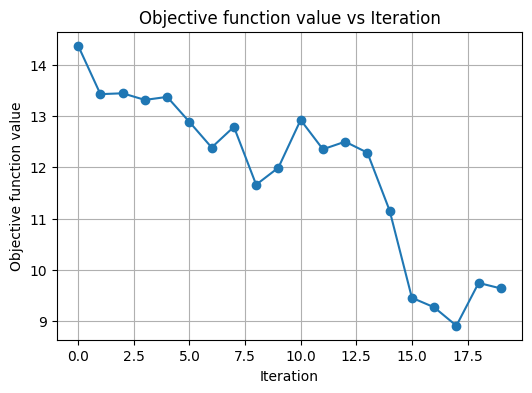

Accuracy from the train data : 5.0%


In [34]:
x = np.asarray(features)
y = np.asarray(labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

## 6. Testing our QCNN

In [35]:
test_ds = ds["train"].select(range(100, 110)).map(process_item)
test_features = [sample["features"] for sample in test_ds]
test_labels = [sample["label"] for sample in test_ds]

Map: 100%|██████████| 10/10 [00:00<00:00, 636.24 examples/s]


In [37]:


y_predict = classifier.predict(test_features)
x = np.asarray(test_features)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")
print("Predicted labels:", y_predict)
print("True labels:", y)


Accuracy from the test data : 0.0%
Predicted labels: [3 2 2 2 3 3 3 3 3 8]
True labels: [5 7 1 7 1 1 6 3 0 2]
